In [1]:
# !pip install tensorflow==2.8.0
# !pip install spektral==1.0.6

In [2]:
import os
import numpy as np

import spektral as spktrl
import tensorflow as tf
keras = tf.keras

from spektral.datasets import Citation, TUDataset
from spektral.data import SingleLoader, DisjointLoader
from spektral.data import Dataset, Graph

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

2023-02-08 11:52:53.001045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 11:53:01.327652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anivlam/GEANT4/install/lib:/usr/lib/x86_64-linux-gnu
2023-02-08 11:53:01.327741: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 11:53:23.815447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: lib

In [3]:
print(f'Using Spektral {spktrl.__version__}')
print(f'Using TensorFlow {tf.__version__}')
print('Physical GPUs:', tf.config.list_physical_devices('GPU'))

Using Spektral 1.2.0
Using TensorFlow 2.11.0
Physical GPUs: []


2023-02-08 11:53:55.316821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anivlam/GEANT4/install/lib:/usr/lib/x86_64-linux-gnu
2023-02-08 11:53:55.324425: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 11:53:55.324630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anivlams-laptop): /proc/driver/nvidia/version does not exist


# Practical graph neural networks in Python with TensorFlow and Spektral

*PyData Berlin, 2022.04.13*

**Abstract**


Graph neural networks (GNNs) have become one of the hottest research topics in recent years. Their popularity is reinforced by hugely successful industry applications in social networks, biology, chemistry, neuroscience and many other areas. One of the main challenges faced by data scientists and researchers who want to apply graph networks in their work is that they require different data structures and a slightly different training approach than traditional deep learning models. During the workshop we’ll demonstrate how to implement graph neural networks, how to prepare your data and – finally – how to train a GNN model for node-level and graph-level tasks using Spektral and TensorFlow.



## 1. Node classification with functional API

We'll perform node classification using [CORA](https://relational.fit.cvut.cz/dataset/CORA) citation dataset

### 1.1 Get the data

In [4]:
# Load data
dataset = Citation("cora", normalize_x=True)

Pre-processing node features


/home/anivlam/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### 1.2 EDA

In [7]:
len(dataset)

1

In [6]:
# Let's understand the adjacency matrix
dataset[0].a

IndexError: list index out of range

In [7]:
# Let's understand labels
dataset[0].y.shape

(2708, 7)

#### Exercise 1.2.1

Display the label of node 77. 


What is the label of this node?

In [8]:
# YOUR CODE HERE
dataset[0].y[76]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [9]:
# Let't understand features
dataset[0].x.shape

(2708, 1433)

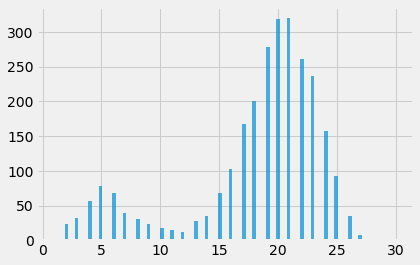

In [10]:
# Check the distribution of non-zero featueres over nodes
plt.hist((dataset[0].x > 0).sum(axis=1), alpha=.7, bins=100)
plt.show()

In [11]:
# Understand the masks 

# Training, val, test 
dataset.mask_tr, dataset.mask_va, dataset.mask_te

(array([ True,  True,  True, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ...,  True,  True,  True]))

#### Exercise 1.2.2

Compute the number of training, validation and test examples. 

What are these numbers?

In [12]:
# YOUR CODE HERE
print(f'Number of training examples: {dataset.mask_tr.sum()}')
print(f'Number of validation examples: {dataset.mask_va.sum()}')
print(f'Number of test examples: {dataset.mask_te.sum()}')

Number of training examples: 140
Number of validation examples: 500
Number of test examples: 1000


### 1.3 Prepare dataloaders

In [13]:
loader_tr = SingleLoader(dataset)
loader_va = SingleLoader(dataset)

### 1.4 Build and compile the model

#### 1.4.1 Build

In [14]:
# Inputs
in_x = keras.Input(shape=(dataset[0].x.shape[1],))
in_a = keras.Input(shape=(dataset[0].a.shape[0],), sparse=True)

In [15]:
# Add dropout on features (but not adjacency matrix)
dropout_1 = keras.layers.Dropout(.1)(in_x)

In [16]:
# Add GAT layer
gat_layer_1 = spktrl.layers.GATConv(
    channels=16,
    attn_heads=8,
    concat_heads=True,
    dropout_rate=.05,
    activation='selu',
    kernel_initializer='lecun_normal'
)([dropout_1, in_a])

2023-01-27 11:48:30.716819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/anivlam/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [17]:
# Add dropout
dropout_2 = keras.layers.Dropout(.1)(gat_layer_1)

In [18]:
# Final GAT layer
gat_out = spktrl.layers.GATConv(
    channels=dataset[0].n_labels,
    attn_heads=8,
    concat_heads=False,
    dropout_rate=.05,
    activation='softmax'
)([dropout_2, in_a])

In [19]:
# Enclose the layers in the model
model = keras.Model(inputs=[in_x, in_a], outputs=gat_out)

#### 1.4.2 Setup and compile

In [20]:
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10000  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

In [21]:
# Compile the model
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gat_conv (GATConv)             (None, 128)          183808      ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

#### 1.4.3 Train

In [22]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=PATIENCE//2, min_lr=5e-6, factor=.9)
]

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10000
1/1 [==============================] - 4s 4s/step - loss: 5269.5479 - acc: 0.1787 - val_loss: 5266.0054 - val_acc: 0.3091 - lr: 0.0010
Epoch 2/10000
1/1 [==============================] - 0s 171ms/step - loss: 5266.0034 - acc: 0.3083 - val_loss: 5262.2236 - val_acc: 0.3028 - lr: 0.0010
Epoch 3/10000
1/1 [==============================] - 0s 222ms/step - loss: 5262.2500 - acc: 0.3035 - val_loss: 5257.9819 - val_acc: 0.3021 - lr: 0.0010
Epoch 4/10000
1/1 [==============================] - 0s 156ms/step - loss: 5257.9907 - acc: 0.3021 - val_loss: 5253.2139 - val_acc: 0.3021 - lr: 0.0010
Epoch 5/10000
1/1 [==============================] - 0s 146ms/step - loss: 5253.1792 - acc: 0.3035 - val_loss: 5247.8848 - val_acc: 0.3021 - lr: 0.0010
Epoch 6/10000
1/1 [==============================] - 0s 149ms/step - loss: 5247.9219 - acc: 0.3021 - val_loss: 5241.9678 - val_acc: 0.3021 - lr: 0.0010
Epoch 7/10000
1/1 [==============================] - 0s 153ms/step - loss: 5242.0088 - acc:

Epoch 55/10000
1/1 [==============================] - 0s 151ms/step - loss: 4583.1025 - acc: 0.3021 - val_loss: 4569.8218 - val_acc: 0.3021 - lr: 0.0010
Epoch 56/10000
1/1 [==============================] - 0s 138ms/step - loss: 4567.3589 - acc: 0.3021 - val_loss: 4553.8237 - val_acc: 0.3021 - lr: 0.0010
Epoch 57/10000
1/1 [==============================] - 0s 135ms/step - loss: 4551.8477 - acc: 0.3021 - val_loss: 4537.4038 - val_acc: 0.3021 - lr: 0.0010
Epoch 58/10000
1/1 [==============================] - 0s 137ms/step - loss: 4540.6128 - acc: 0.3021 - val_loss: 4520.5923 - val_acc: 0.3021 - lr: 0.0010
Epoch 59/10000
1/1 [==============================] - 0s 139ms/step - loss: 4521.8960 - acc: 0.3021 - val_loss: 4503.3882 - val_acc: 0.3021 - lr: 0.0010
Epoch 60/10000
1/1 [==============================] - 0s 144ms/step - loss: 4504.9478 - acc: 0.3021 - val_loss: 4485.7949 - val_acc: 0.3021 - lr: 0.0010
Epoch 61/10000
1/1 [==============================] - 0s 142ms/step - loss: 4487.8

1/1 [==============================] - 0s 168ms/step - loss: 1937.3429 - acc: 0.8401 - val_loss: 1905.7157 - val_acc: 0.8427 - lr: 0.0010
Epoch 162/10000
1/1 [==============================] - 0s 151ms/step - loss: 1913.5148 - acc: 0.8349 - val_loss: 1890.2463 - val_acc: 0.8438 - lr: 0.0010
Epoch 163/10000
1/1 [==============================] - 0s 143ms/step - loss: 1897.1329 - acc: 0.8394 - val_loss: 1875.0004 - val_acc: 0.8445 - lr: 0.0010
Epoch 164/10000
1/1 [==============================] - 0s 145ms/step - loss: 1891.2911 - acc: 0.8401 - val_loss: 1859.9760 - val_acc: 0.8460 - lr: 0.0010
Epoch 165/10000
1/1 [==============================] - 0s 142ms/step - loss: 1880.4496 - acc: 0.8416 - val_loss: 1845.1555 - val_acc: 0.8468 - lr: 0.0010
Epoch 166/10000
1/1 [==============================] - 0s 133ms/step - loss: 1870.2040 - acc: 0.8419 - val_loss: 1830.5469 - val_acc: 0.8479 - lr: 0.0010
Epoch 167/10000
1/1 [==============================] - 0s 131ms/step - loss: 1854.3157 - acc

1/1 [==============================] - 0s 144ms/step - loss: 992.0527 - acc: 0.9117 - val_loss: 968.4260 - val_acc: 0.9077 - lr: 0.0010
Epoch 268/10000
1/1 [==============================] - 0s 140ms/step - loss: 1001.4277 - acc: 0.9040 - val_loss: 963.7918 - val_acc: 0.9081 - lr: 0.0010
Epoch 269/10000
1/1 [==============================] - 0s 169ms/step - loss: 988.0604 - acc: 0.9084 - val_loss: 959.1920 - val_acc: 0.9081 - lr: 0.0010
Epoch 270/10000
1/1 [==============================] - 0s 154ms/step - loss: 985.3001 - acc: 0.9095 - val_loss: 954.6514 - val_acc: 0.9092 - lr: 0.0010
Epoch 271/10000
1/1 [==============================] - 0s 137ms/step - loss: 972.8456 - acc: 0.9106 - val_loss: 950.1501 - val_acc: 0.9106 - lr: 0.0010
Epoch 272/10000
1/1 [==============================] - 0s 136ms/step - loss: 964.3615 - acc: 0.9114 - val_loss: 945.7008 - val_acc: 0.9106 - lr: 0.0010
Epoch 273/10000
1/1 [==============================] - 0s 174ms/step - loss: 959.5807 - acc: 0.9106 - v

Epoch 321/10000
1/1 [==============================] - 0s 144ms/step - loss: 791.6592 - acc: 0.9206 - val_loss: 773.8393 - val_acc: 0.9239 - lr: 0.0010
Epoch 322/10000
1/1 [==============================] - 0s 179ms/step - loss: 796.8981 - acc: 0.9202 - val_loss: 771.1249 - val_acc: 0.9243 - lr: 0.0010
Epoch 323/10000
1/1 [==============================] - 0s 148ms/step - loss: 793.6104 - acc: 0.9247 - val_loss: 768.4462 - val_acc: 0.9243 - lr: 0.0010
Epoch 324/10000
1/1 [==============================] - 0s 140ms/step - loss: 802.0230 - acc: 0.9206 - val_loss: 765.7690 - val_acc: 0.9247 - lr: 0.0010
Epoch 325/10000
1/1 [==============================] - 0s 143ms/step - loss: 788.4452 - acc: 0.9188 - val_loss: 763.1246 - val_acc: 0.9247 - lr: 0.0010
Epoch 326/10000
1/1 [==============================] - 0s 141ms/step - loss: 780.0357 - acc: 0.9210 - val_loss: 760.4890 - val_acc: 0.9250 - lr: 0.0010
Epoch 327/10000
1/1 [==============================] - 0s 138ms/step - loss: 796.9655 - 

Epoch 375/10000
1/1 [==============================] - 0s 153ms/step - loss: 683.1137 - acc: 0.9265 - val_loss: 653.6661 - val_acc: 0.9324 - lr: 0.0010
Epoch 376/10000
1/1 [==============================] - 0s 177ms/step - loss: 690.9809 - acc: 0.9291 - val_loss: 651.8352 - val_acc: 0.9328 - lr: 0.0010
Epoch 377/10000
1/1 [==============================] - 0s 143ms/step - loss: 677.2164 - acc: 0.9287 - val_loss: 650.0031 - val_acc: 0.9328 - lr: 0.0010
Epoch 378/10000
1/1 [==============================] - 0s 143ms/step - loss: 680.1785 - acc: 0.9313 - val_loss: 648.1898 - val_acc: 0.9332 - lr: 0.0010
Epoch 379/10000
1/1 [==============================] - 0s 141ms/step - loss: 673.9351 - acc: 0.9276 - val_loss: 646.3856 - val_acc: 0.9332 - lr: 0.0010
Epoch 380/10000
1/1 [==============================] - 0s 145ms/step - loss: 672.8715 - acc: 0.9295 - val_loss: 644.5860 - val_acc: 0.9343 - lr: 0.0010
Epoch 381/10000
1/1 [==============================] - 0s 142ms/step - loss: 674.3868 - 

Epoch 429/10000
1/1 [==============================] - 0s 147ms/step - loss: 605.5947 - acc: 0.9324 - val_loss: 567.6969 - val_acc: 0.9380 - lr: 0.0010
Epoch 430/10000
1/1 [==============================] - 0s 169ms/step - loss: 599.9821 - acc: 0.9376 - val_loss: 566.2864 - val_acc: 0.9380 - lr: 0.0010
Epoch 431/10000
1/1 [==============================] - 0s 164ms/step - loss: 597.6644 - acc: 0.9335 - val_loss: 564.8681 - val_acc: 0.9380 - lr: 0.0010
Epoch 432/10000
1/1 [==============================] - 0s 145ms/step - loss: 587.8646 - acc: 0.9343 - val_loss: 563.3844 - val_acc: 0.9387 - lr: 0.0010
Epoch 433/10000
1/1 [==============================] - 0s 142ms/step - loss: 594.3682 - acc: 0.9335 - val_loss: 561.9042 - val_acc: 0.9387 - lr: 0.0010
Epoch 434/10000
1/1 [==============================] - 0s 142ms/step - loss: 592.1606 - acc: 0.9343 - val_loss: 560.4685 - val_acc: 0.9394 - lr: 0.0010
Epoch 435/10000
1/1 [==============================] - 0s 139ms/step - loss: 591.7321 - 

Epoch 483/10000
1/1 [==============================] - 0s 143ms/step - loss: 530.3513 - acc: 0.9398 - val_loss: 498.9425 - val_acc: 0.9457 - lr: 0.0010
Epoch 484/10000
1/1 [==============================] - 0s 151ms/step - loss: 527.3679 - acc: 0.9398 - val_loss: 497.7693 - val_acc: 0.9457 - lr: 0.0010
Epoch 485/10000
1/1 [==============================] - 0s 173ms/step - loss: 520.8618 - acc: 0.9409 - val_loss: 496.5850 - val_acc: 0.9457 - lr: 0.0010
Epoch 486/10000
1/1 [==============================] - 0s 146ms/step - loss: 526.0240 - acc: 0.9402 - val_loss: 495.3964 - val_acc: 0.9457 - lr: 0.0010
Epoch 487/10000
1/1 [==============================] - 0s 146ms/step - loss: 529.0087 - acc: 0.9380 - val_loss: 494.2228 - val_acc: 0.9457 - lr: 0.0010
Epoch 488/10000
1/1 [==============================] - 0s 144ms/step - loss: 541.4275 - acc: 0.9405 - val_loss: 493.0667 - val_acc: 0.9457 - lr: 0.0010
Epoch 489/10000
1/1 [==============================] - 0s 141ms/step - loss: 519.9792 - 

Epoch 537/10000
1/1 [==============================] - 0s 143ms/step - loss: 467.6768 - acc: 0.9442 - val_loss: 440.2931 - val_acc: 0.9538 - lr: 0.0010
Epoch 538/10000
1/1 [==============================] - 0s 145ms/step - loss: 467.1201 - acc: 0.9468 - val_loss: 439.3175 - val_acc: 0.9538 - lr: 0.0010
Epoch 539/10000
1/1 [==============================] - 0s 238ms/step - loss: 465.4660 - acc: 0.9487 - val_loss: 438.3515 - val_acc: 0.9538 - lr: 0.0010
Epoch 540/10000
1/1 [==============================] - 0s 145ms/step - loss: 470.1931 - acc: 0.9442 - val_loss: 437.3766 - val_acc: 0.9542 - lr: 0.0010
Epoch 541/10000
1/1 [==============================] - 0s 155ms/step - loss: 467.6345 - acc: 0.9450 - val_loss: 436.4043 - val_acc: 0.9542 - lr: 0.0010
Epoch 542/10000
1/1 [==============================] - 0s 141ms/step - loss: 482.8481 - acc: 0.9442 - val_loss: 435.4350 - val_acc: 0.9538 - lr: 0.0010
Epoch 543/10000
1/1 [==============================] - 0s 141ms/step - loss: 456.6208 - 

Epoch 591/10000
1/1 [==============================] - 0s 139ms/step - loss: 424.8074 - acc: 0.9527 - val_loss: 390.6189 - val_acc: 0.9564 - lr: 0.0010
Epoch 592/10000
1/1 [==============================] - 0s 166ms/step - loss: 430.8759 - acc: 0.9490 - val_loss: 389.7715 - val_acc: 0.9561 - lr: 0.0010
Epoch 593/10000
1/1 [==============================] - 0s 169ms/step - loss: 413.9545 - acc: 0.9520 - val_loss: 388.9593 - val_acc: 0.9561 - lr: 0.0010
Epoch 594/10000
1/1 [==============================] - 0s 139ms/step - loss: 417.0956 - acc: 0.9520 - val_loss: 388.1641 - val_acc: 0.9557 - lr: 0.0010
Epoch 595/10000
1/1 [==============================] - 0s 163ms/step - loss: 421.2512 - acc: 0.9483 - val_loss: 387.3276 - val_acc: 0.9568 - lr: 0.0010
Epoch 596/10000
1/1 [==============================] - 0s 143ms/step - loss: 419.3442 - acc: 0.9513 - val_loss: 386.5129 - val_acc: 0.9568 - lr: 0.0010
Epoch 597/10000
1/1 [==============================] - 0s 154ms/step - loss: 415.2631 - 

Epoch 645/10000
1/1 [==============================] - 0s 143ms/step - loss: 376.3429 - acc: 0.9561 - val_loss: 346.2018 - val_acc: 0.9594 - lr: 0.0010
Epoch 646/10000
1/1 [==============================] - 0s 155ms/step - loss: 381.0185 - acc: 0.9568 - val_loss: 345.4196 - val_acc: 0.9597 - lr: 0.0010
Epoch 647/10000
1/1 [==============================] - 0s 170ms/step - loss: 380.4449 - acc: 0.9549 - val_loss: 344.6265 - val_acc: 0.9597 - lr: 0.0010
Epoch 648/10000
1/1 [==============================] - 0s 148ms/step - loss: 391.1754 - acc: 0.9520 - val_loss: 343.7672 - val_acc: 0.9601 - lr: 0.0010
Epoch 649/10000
1/1 [==============================] - 0s 142ms/step - loss: 385.5448 - acc: 0.9561 - val_loss: 342.9548 - val_acc: 0.9605 - lr: 0.0010
Epoch 650/10000
1/1 [==============================] - 0s 139ms/step - loss: 369.8869 - acc: 0.9564 - val_loss: 342.1114 - val_acc: 0.9605 - lr: 0.0010
Epoch 651/10000
1/1 [==============================] - 0s 137ms/step - loss: 375.7162 - 

Epoch 699/10000
1/1 [==============================] - 0s 141ms/step - loss: 352.0435 - acc: 0.9542 - val_loss: 305.5779 - val_acc: 0.9649 - lr: 0.0010
Epoch 700/10000
1/1 [==============================] - 0s 140ms/step - loss: 338.9319 - acc: 0.9583 - val_loss: 304.8908 - val_acc: 0.9649 - lr: 0.0010
Epoch 701/10000
1/1 [==============================] - 0s 173ms/step - loss: 346.4077 - acc: 0.9586 - val_loss: 304.2157 - val_acc: 0.9657 - lr: 0.0010
Epoch 702/10000
1/1 [==============================] - 0s 154ms/step - loss: 339.2571 - acc: 0.9572 - val_loss: 303.5760 - val_acc: 0.9660 - lr: 0.0010
Epoch 703/10000
1/1 [==============================] - 0s 141ms/step - loss: 344.3724 - acc: 0.9561 - val_loss: 302.9281 - val_acc: 0.9660 - lr: 0.0010
Epoch 704/10000
1/1 [==============================] - 0s 145ms/step - loss: 337.0602 - acc: 0.9623 - val_loss: 302.3246 - val_acc: 0.9657 - lr: 0.0010
Epoch 705/10000
1/1 [==============================] - 0s 144ms/step - loss: 342.1911 - 

Epoch 753/10000
1/1 [==============================] - 0s 142ms/step - loss: 308.3638 - acc: 0.9631 - val_loss: 273.3901 - val_acc: 0.9690 - lr: 0.0010
Epoch 754/10000
1/1 [==============================] - 0s 137ms/step - loss: 326.0254 - acc: 0.9605 - val_loss: 272.8662 - val_acc: 0.9694 - lr: 0.0010
Epoch 755/10000
1/1 [==============================] - 0s 169ms/step - loss: 311.0629 - acc: 0.9609 - val_loss: 272.2885 - val_acc: 0.9686 - lr: 0.0010
Epoch 756/10000
1/1 [==============================] - 0s 160ms/step - loss: 310.4607 - acc: 0.9583 - val_loss: 271.6973 - val_acc: 0.9686 - lr: 0.0010
Epoch 757/10000
1/1 [==============================] - 0s 143ms/step - loss: 306.9489 - acc: 0.9631 - val_loss: 271.0332 - val_acc: 0.9690 - lr: 0.0010
Epoch 758/10000
1/1 [==============================] - 0s 145ms/step - loss: 301.4197 - acc: 0.9645 - val_loss: 270.3601 - val_acc: 0.9697 - lr: 0.0010
Epoch 759/10000
1/1 [==============================] - 0s 149ms/step - loss: 311.0547 - 

Epoch 807/10000
1/1 [==============================] - 0s 142ms/step - loss: 297.9683 - acc: 0.9627 - val_loss: 245.0719 - val_acc: 0.9719 - lr: 0.0010
Epoch 808/10000
1/1 [==============================] - 0s 141ms/step - loss: 286.2896 - acc: 0.9657 - val_loss: 244.5712 - val_acc: 0.9719 - lr: 0.0010
Epoch 809/10000
1/1 [==============================] - 0s 144ms/step - loss: 285.9338 - acc: 0.9671 - val_loss: 244.0795 - val_acc: 0.9719 - lr: 0.0010
Epoch 810/10000
1/1 [==============================] - 0s 174ms/step - loss: 289.5192 - acc: 0.9660 - val_loss: 243.5879 - val_acc: 0.9719 - lr: 0.0010
Epoch 811/10000
1/1 [==============================] - 0s 141ms/step - loss: 294.0320 - acc: 0.9671 - val_loss: 243.0988 - val_acc: 0.9723 - lr: 0.0010
Epoch 812/10000
1/1 [==============================] - 0s 143ms/step - loss: 285.8091 - acc: 0.9682 - val_loss: 242.6197 - val_acc: 0.9723 - lr: 0.0010
Epoch 813/10000
1/1 [==============================] - 0s 145ms/step - loss: 285.5409 - 

Epoch 861/10000
1/1 [==============================] - 0s 168ms/step - loss: 265.9179 - acc: 0.9657 - val_loss: 221.4637 - val_acc: 0.9753 - lr: 0.0010
Epoch 862/10000
1/1 [==============================] - 0s 153ms/step - loss: 266.6286 - acc: 0.9690 - val_loss: 221.0358 - val_acc: 0.9753 - lr: 0.0010
Epoch 863/10000
1/1 [==============================] - 0s 166ms/step - loss: 272.4167 - acc: 0.9657 - val_loss: 220.6650 - val_acc: 0.9753 - lr: 0.0010
Epoch 864/10000
1/1 [==============================] - 0s 208ms/step - loss: 274.2634 - acc: 0.9660 - val_loss: 220.3588 - val_acc: 0.9753 - lr: 0.0010
Epoch 865/10000
1/1 [==============================] - 0s 157ms/step - loss: 254.7465 - acc: 0.9701 - val_loss: 220.0851 - val_acc: 0.9756 - lr: 0.0010
Epoch 866/10000
1/1 [==============================] - 0s 194ms/step - loss: 261.9559 - acc: 0.9694 - val_loss: 219.7667 - val_acc: 0.9753 - lr: 0.0010
Epoch 867/10000
1/1 [==============================] - 0s 154ms/step - loss: 261.1449 - 

Epoch 915/10000
1/1 [==============================] - 0s 158ms/step - loss: 246.1789 - acc: 0.9690 - val_loss: 201.2395 - val_acc: 0.9771 - lr: 0.0010
Epoch 916/10000
1/1 [==============================] - 0s 173ms/step - loss: 241.9970 - acc: 0.9716 - val_loss: 200.8355 - val_acc: 0.9775 - lr: 0.0010
Epoch 917/10000
1/1 [==============================] - 0s 150ms/step - loss: 239.9883 - acc: 0.9723 - val_loss: 200.4274 - val_acc: 0.9778 - lr: 0.0010
Epoch 918/10000
1/1 [==============================] - 0s 179ms/step - loss: 233.6653 - acc: 0.9723 - val_loss: 200.0360 - val_acc: 0.9778 - lr: 0.0010
Epoch 919/10000
1/1 [==============================] - 0s 190ms/step - loss: 245.5692 - acc: 0.9675 - val_loss: 199.6415 - val_acc: 0.9778 - lr: 0.0010
Epoch 920/10000
1/1 [==============================] - 0s 173ms/step - loss: 246.1426 - acc: 0.9697 - val_loss: 199.2893 - val_acc: 0.9778 - lr: 0.0010
Epoch 921/10000
1/1 [==============================] - 0s 163ms/step - loss: 246.2522 - 

Epoch 969/10000
1/1 [==============================] - 0s 142ms/step - loss: 229.7524 - acc: 0.9730 - val_loss: 183.0000 - val_acc: 0.9793 - lr: 0.0010
Epoch 970/10000
1/1 [==============================] - 0s 141ms/step - loss: 223.2032 - acc: 0.9734 - val_loss: 182.6156 - val_acc: 0.9793 - lr: 0.0010
Epoch 971/10000
1/1 [==============================] - 0s 143ms/step - loss: 216.1300 - acc: 0.9708 - val_loss: 182.2751 - val_acc: 0.9793 - lr: 0.0010
Epoch 972/10000
1/1 [==============================] - 0s 145ms/step - loss: 235.3441 - acc: 0.9705 - val_loss: 182.0024 - val_acc: 0.9797 - lr: 0.0010
Epoch 973/10000
1/1 [==============================] - 0s 139ms/step - loss: 220.5372 - acc: 0.9716 - val_loss: 181.7387 - val_acc: 0.9797 - lr: 0.0010
Epoch 974/10000
1/1 [==============================] - 0s 139ms/step - loss: 223.7670 - acc: 0.9708 - val_loss: 181.4979 - val_acc: 0.9804 - lr: 0.0010
Epoch 975/10000
1/1 [==============================] - 0s 137ms/step - loss: 222.3437 - 

Epoch 1023/10000
1/1 [==============================] - 0s 141ms/step - loss: 214.3255 - acc: 0.9753 - val_loss: 167.3397 - val_acc: 0.9812 - lr: 0.0010
Epoch 1024/10000
1/1 [==============================] - 0s 141ms/step - loss: 205.9670 - acc: 0.9760 - val_loss: 166.9933 - val_acc: 0.9815 - lr: 0.0010
Epoch 1025/10000
1/1 [==============================] - 0s 140ms/step - loss: 210.6528 - acc: 0.9730 - val_loss: 166.6761 - val_acc: 0.9819 - lr: 0.0010
Epoch 1026/10000
1/1 [==============================] - 0s 138ms/step - loss: 209.2840 - acc: 0.9719 - val_loss: 166.3766 - val_acc: 0.9819 - lr: 0.0010
Epoch 1027/10000
1/1 [==============================] - 0s 141ms/step - loss: 205.6115 - acc: 0.9771 - val_loss: 166.1159 - val_acc: 0.9812 - lr: 0.0010
Epoch 1028/10000
1/1 [==============================] - 0s 141ms/step - loss: 218.7600 - acc: 0.9745 - val_loss: 165.8553 - val_acc: 0.9812 - lr: 0.0010
Epoch 1029/10000
1/1 [==============================] - 0s 132ms/step - loss: 206.

Epoch 1130/10000
1/1 [==============================] - 0s 145ms/step - loss: 183.6091 - acc: 0.9790 - val_loss: 140.5897 - val_acc: 0.9849 - lr: 0.0010
Epoch 1131/10000
1/1 [==============================] - 0s 135ms/step - loss: 182.3023 - acc: 0.9786 - val_loss: 140.4148 - val_acc: 0.9852 - lr: 0.0010
Epoch 1132/10000
1/1 [==============================] - 0s 136ms/step - loss: 183.0228 - acc: 0.9760 - val_loss: 140.2393 - val_acc: 0.9852 - lr: 0.0010
Epoch 1133/10000
1/1 [==============================] - 0s 143ms/step - loss: 183.8919 - acc: 0.9790 - val_loss: 140.0476 - val_acc: 0.9852 - lr: 0.0010
Epoch 1134/10000
1/1 [==============================] - 0s 136ms/step - loss: 202.9763 - acc: 0.9756 - val_loss: 139.8476 - val_acc: 0.9852 - lr: 0.0010
Epoch 1135/10000
1/1 [==============================] - 0s 137ms/step - loss: 183.6144 - acc: 0.9786 - val_loss: 139.6390 - val_acc: 0.9852 - lr: 0.0010
Epoch 1136/10000
1/1 [==============================] - 0s 134ms/step - loss: 197.

Epoch 1237/10000
1/1 [==============================] - 0s 172ms/step - loss: 166.1493 - acc: 0.9797 - val_loss: 118.7063 - val_acc: 0.9867 - lr: 0.0010
Epoch 1238/10000
1/1 [==============================] - 0s 162ms/step - loss: 162.7238 - acc: 0.9797 - val_loss: 118.4851 - val_acc: 0.9867 - lr: 0.0010
Epoch 1239/10000
1/1 [==============================] - 0s 135ms/step - loss: 163.9891 - acc: 0.9812 - val_loss: 118.2683 - val_acc: 0.9863 - lr: 0.0010
Epoch 1240/10000
1/1 [==============================] - 0s 137ms/step - loss: 154.4068 - acc: 0.9826 - val_loss: 118.0756 - val_acc: 0.9863 - lr: 0.0010
Epoch 1241/10000
1/1 [==============================] - 0s 136ms/step - loss: 163.8873 - acc: 0.9786 - val_loss: 117.8632 - val_acc: 0.9863 - lr: 0.0010
Epoch 1242/10000
1/1 [==============================] - 0s 137ms/step - loss: 164.7835 - acc: 0.9793 - val_loss: 117.6701 - val_acc: 0.9860 - lr: 0.0010
Epoch 1243/10000
1/1 [==============================] - 0s 135ms/step - loss: 168.

Epoch 1344/10000
1/1 [==============================] - 0s 137ms/step - loss: 140.0231 - acc: 0.9838 - val_loss: 101.4874 - val_acc: 0.9889 - lr: 0.0010
Epoch 1345/10000
1/1 [==============================] - 0s 161ms/step - loss: 150.6246 - acc: 0.9797 - val_loss: 101.3343 - val_acc: 0.9889 - lr: 0.0010
Epoch 1346/10000
1/1 [==============================] - 0s 166ms/step - loss: 146.5229 - acc: 0.9826 - val_loss: 101.1417 - val_acc: 0.9886 - lr: 0.0010
Epoch 1347/10000
1/1 [==============================] - 0s 135ms/step - loss: 147.0046 - acc: 0.9808 - val_loss: 100.9672 - val_acc: 0.9889 - lr: 0.0010
Epoch 1348/10000
1/1 [==============================] - 0s 144ms/step - loss: 144.9921 - acc: 0.9838 - val_loss: 100.7732 - val_acc: 0.9889 - lr: 0.0010
Epoch 1349/10000
1/1 [==============================] - 0s 141ms/step - loss: 143.2571 - acc: 0.9838 - val_loss: 100.5520 - val_acc: 0.9889 - lr: 0.0010
Epoch 1350/10000
1/1 [==============================] - 0s 139ms/step - loss: 153.

Epoch 1398/10000
1/1 [==============================] - 0s 172ms/step - loss: 135.2487 - acc: 0.9808 - val_loss: 93.9211 - val_acc: 0.9893 - lr: 0.0010
Epoch 1399/10000
1/1 [==============================] - 0s 165ms/step - loss: 132.2094 - acc: 0.9849 - val_loss: 93.7630 - val_acc: 0.9893 - lr: 0.0010
Epoch 1400/10000
1/1 [==============================] - 0s 135ms/step - loss: 136.6213 - acc: 0.9849 - val_loss: 93.6358 - val_acc: 0.9893 - lr: 0.0010
Epoch 1401/10000
1/1 [==============================] - 0s 142ms/step - loss: 132.1937 - acc: 0.9838 - val_loss: 93.5305 - val_acc: 0.9897 - lr: 0.0010
Epoch 1402/10000
1/1 [==============================] - 0s 146ms/step - loss: 126.5678 - acc: 0.9856 - val_loss: 93.4602 - val_acc: 0.9904 - lr: 0.0010
Epoch 1403/10000
1/1 [==============================] - 0s 142ms/step - loss: 131.4244 - acc: 0.9838 - val_loss: 93.3768 - val_acc: 0.9904 - lr: 0.0010
Epoch 1404/10000
1/1 [==============================] - 0s 139ms/step - loss: 133.8520 -

Epoch 1452/10000
1/1 [==============================] - 0s 158ms/step - loss: 120.3753 - acc: 0.9856 - val_loss: 87.1985 - val_acc: 0.9897 - lr: 0.0010
Epoch 1453/10000
1/1 [==============================] - 0s 137ms/step - loss: 122.1763 - acc: 0.9849 - val_loss: 87.0666 - val_acc: 0.9900 - lr: 0.0010
Epoch 1454/10000
1/1 [==============================] - 0s 143ms/step - loss: 127.5720 - acc: 0.9849 - val_loss: 86.9471 - val_acc: 0.9900 - lr: 0.0010
Epoch 1455/10000
1/1 [==============================] - 0s 173ms/step - loss: 132.5693 - acc: 0.9856 - val_loss: 86.8515 - val_acc: 0.9904 - lr: 0.0010
Epoch 1456/10000
1/1 [==============================] - 0s 139ms/step - loss: 131.5522 - acc: 0.9860 - val_loss: 86.7797 - val_acc: 0.9904 - lr: 0.0010
Epoch 1457/10000
1/1 [==============================] - 0s 142ms/step - loss: 138.2735 - acc: 0.9830 - val_loss: 86.7380 - val_acc: 0.9900 - lr: 0.0010
Epoch 1458/10000
1/1 [==============================] - 0s 137ms/step - loss: 133.4311 -

Epoch 1506/10000
1/1 [==============================] - 0s 164ms/step - loss: 120.3091 - acc: 0.9871 - val_loss: 81.6305 - val_acc: 0.9919 - lr: 0.0010
Epoch 1507/10000
1/1 [==============================] - 0s 140ms/step - loss: 116.4635 - acc: 0.9878 - val_loss: 81.5436 - val_acc: 0.9919 - lr: 0.0010
Epoch 1508/10000
1/1 [==============================] - 0s 143ms/step - loss: 126.3503 - acc: 0.9845 - val_loss: 81.4568 - val_acc: 0.9919 - lr: 0.0010
Epoch 1509/10000
1/1 [==============================] - 0s 140ms/step - loss: 116.9900 - acc: 0.9863 - val_loss: 81.3714 - val_acc: 0.9919 - lr: 0.0010
Epoch 1510/10000
1/1 [==============================] - 0s 141ms/step - loss: 113.8160 - acc: 0.9871 - val_loss: 81.2877 - val_acc: 0.9919 - lr: 0.0010
Epoch 1511/10000
1/1 [==============================] - 0s 140ms/step - loss: 117.3821 - acc: 0.9860 - val_loss: 81.1790 - val_acc: 0.9919 - lr: 0.0010
Epoch 1512/10000
1/1 [==============================] - 0s 139ms/step - loss: 121.2659 -

Epoch 1560/10000
1/1 [==============================] - 0s 167ms/step - loss: 110.0233 - acc: 0.9893 - val_loss: 76.4379 - val_acc: 0.9922 - lr: 0.0010
Epoch 1561/10000
1/1 [==============================] - 0s 144ms/step - loss: 129.9881 - acc: 0.9834 - val_loss: 76.3958 - val_acc: 0.9922 - lr: 0.0010
Epoch 1562/10000
1/1 [==============================] - 0s 141ms/step - loss: 111.3523 - acc: 0.9871 - val_loss: 76.3987 - val_acc: 0.9922 - lr: 0.0010
Epoch 1563/10000
1/1 [==============================] - 0s 140ms/step - loss: 109.1071 - acc: 0.9878 - val_loss: 76.3843 - val_acc: 0.9922 - lr: 0.0010
Epoch 1564/10000
1/1 [==============================] - 0s 135ms/step - loss: 113.2686 - acc: 0.9856 - val_loss: 76.3499 - val_acc: 0.9922 - lr: 0.0010
Epoch 1565/10000
1/1 [==============================] - 0s 141ms/step - loss: 111.3037 - acc: 0.9874 - val_loss: 76.2583 - val_acc: 0.9922 - lr: 0.0010
Epoch 1566/10000
1/1 [==============================] - 0s 140ms/step - loss: 111.1925 -

Epoch 1614/10000
1/1 [==============================] - 0s 148ms/step - loss: 106.0624 - acc: 0.9874 - val_loss: 71.7906 - val_acc: 0.9926 - lr: 0.0010
Epoch 1615/10000
1/1 [==============================] - 0s 140ms/step - loss: 113.0265 - acc: 0.9874 - val_loss: 71.6552 - val_acc: 0.9922 - lr: 0.0010
Epoch 1616/10000
1/1 [==============================] - 0s 142ms/step - loss: 107.7712 - acc: 0.9893 - val_loss: 71.5095 - val_acc: 0.9930 - lr: 0.0010
Epoch 1617/10000
1/1 [==============================] - 0s 136ms/step - loss: 109.5512 - acc: 0.9849 - val_loss: 71.3869 - val_acc: 0.9926 - lr: 0.0010
Epoch 1618/10000
1/1 [==============================] - 0s 137ms/step - loss: 103.9955 - acc: 0.9886 - val_loss: 71.2862 - val_acc: 0.9926 - lr: 0.0010
Epoch 1619/10000
1/1 [==============================] - 0s 136ms/step - loss: 116.5758 - acc: 0.9852 - val_loss: 71.1904 - val_acc: 0.9930 - lr: 0.0010
Epoch 1620/10000
1/1 [==============================] - 0s 136ms/step - loss: 107.8990 -

Epoch 1668/10000
1/1 [==============================] - 0s 171ms/step - loss: 114.7134 - acc: 0.9860 - val_loss: 67.8931 - val_acc: 0.9922 - lr: 0.0010
Epoch 1669/10000
1/1 [==============================] - 0s 140ms/step - loss: 104.8633 - acc: 0.9867 - val_loss: 67.8606 - val_acc: 0.9922 - lr: 0.0010
Epoch 1670/10000
1/1 [==============================] - 0s 141ms/step - loss: 109.3819 - acc: 0.9874 - val_loss: 67.7992 - val_acc: 0.9926 - lr: 0.0010
Epoch 1671/10000
1/1 [==============================] - 0s 144ms/step - loss: 104.0949 - acc: 0.9886 - val_loss: 67.6767 - val_acc: 0.9930 - lr: 0.0010
Epoch 1672/10000
1/1 [==============================] - 0s 141ms/step - loss: 103.5385 - acc: 0.9893 - val_loss: 67.5417 - val_acc: 0.9930 - lr: 0.0010
Epoch 1673/10000
1/1 [==============================] - 0s 140ms/step - loss: 100.4452 - acc: 0.9882 - val_loss: 67.3943 - val_acc: 0.9926 - lr: 0.0010
Epoch 1674/10000
1/1 [==============================] - 0s 140ms/step - loss: 110.2634 -

Epoch 1722/10000
1/1 [==============================] - 0s 149ms/step - loss: 95.8018 - acc: 0.9882 - val_loss: 63.7635 - val_acc: 0.9937 - lr: 0.0010
Epoch 1723/10000
1/1 [==============================] - 0s 133ms/step - loss: 99.8909 - acc: 0.9882 - val_loss: 63.7010 - val_acc: 0.9937 - lr: 0.0010
Epoch 1724/10000
1/1 [==============================] - 0s 140ms/step - loss: 102.1020 - acc: 0.9889 - val_loss: 63.6842 - val_acc: 0.9937 - lr: 0.0010
Epoch 1725/10000
1/1 [==============================] - 0s 144ms/step - loss: 99.3862 - acc: 0.9882 - val_loss: 63.6570 - val_acc: 0.9937 - lr: 0.0010
Epoch 1726/10000
1/1 [==============================] - 0s 143ms/step - loss: 101.4089 - acc: 0.9860 - val_loss: 63.5592 - val_acc: 0.9937 - lr: 0.0010
Epoch 1727/10000
1/1 [==============================] - 0s 138ms/step - loss: 99.0364 - acc: 0.9882 - val_loss: 63.4542 - val_acc: 0.9941 - lr: 0.0010
Epoch 1728/10000
1/1 [==============================] - 0s 140ms/step - loss: 99.9874 - acc:

1/1 [==============================] - 0s 170ms/step - loss: 93.4490 - acc: 0.9897 - val_loss: 57.3986 - val_acc: 0.9952 - lr: 0.0010
Epoch 1831/10000
1/1 [==============================] - 0s 136ms/step - loss: 87.2766 - acc: 0.9904 - val_loss: 57.3585 - val_acc: 0.9948 - lr: 0.0010
Epoch 1832/10000
1/1 [==============================] - 0s 140ms/step - loss: 98.7990 - acc: 0.9893 - val_loss: 57.3332 - val_acc: 0.9952 - lr: 0.0010
Epoch 1833/10000
1/1 [==============================] - 0s 144ms/step - loss: 95.5811 - acc: 0.9886 - val_loss: 57.3000 - val_acc: 0.9952 - lr: 0.0010
Epoch 1834/10000
1/1 [==============================] - 0s 141ms/step - loss: 95.1098 - acc: 0.9889 - val_loss: 57.2672 - val_acc: 0.9952 - lr: 0.0010
Epoch 1835/10000
1/1 [==============================] - 0s 135ms/step - loss: 82.0221 - acc: 0.9908 - val_loss: 57.2237 - val_acc: 0.9952 - lr: 0.0010
Epoch 1836/10000
1/1 [==============================] - 0s 146ms/step - loss: 98.3462 - acc: 0.9852 - val_loss:

1/1 [==============================] - 0s 141ms/step - loss: 90.8500 - acc: 0.9889 - val_loss: 51.9426 - val_acc: 0.9948 - lr: 0.0010
Epoch 1939/10000
1/1 [==============================] - 0s 138ms/step - loss: 96.3037 - acc: 0.9886 - val_loss: 51.9109 - val_acc: 0.9948 - lr: 0.0010
Epoch 1940/10000
1/1 [==============================] - 0s 145ms/step - loss: 84.5490 - acc: 0.9897 - val_loss: 51.8440 - val_acc: 0.9948 - lr: 0.0010
Epoch 1941/10000
1/1 [==============================] - 0s 138ms/step - loss: 88.6615 - acc: 0.9897 - val_loss: 51.7632 - val_acc: 0.9952 - lr: 0.0010
Epoch 1942/10000
1/1 [==============================] - 0s 138ms/step - loss: 89.0265 - acc: 0.9882 - val_loss: 51.7035 - val_acc: 0.9952 - lr: 0.0010
Epoch 1943/10000
1/1 [==============================] - 0s 139ms/step - loss: 80.1193 - acc: 0.9904 - val_loss: 51.6457 - val_acc: 0.9952 - lr: 0.0010
Epoch 1944/10000
1/1 [==============================] - 0s 141ms/step - loss: 85.1922 - acc: 0.9900 - val_loss:

1/1 [==============================] - 0s 142ms/step - loss: 82.5177 - acc: 0.9908 - val_loss: 47.4793 - val_acc: 0.9956 - lr: 0.0010
Epoch 2047/10000
1/1 [==============================] - 0s 134ms/step - loss: 72.9228 - acc: 0.9900 - val_loss: 47.4224 - val_acc: 0.9956 - lr: 0.0010
Epoch 2048/10000
1/1 [==============================] - 0s 144ms/step - loss: 75.5273 - acc: 0.9897 - val_loss: 47.3604 - val_acc: 0.9956 - lr: 0.0010
Epoch 2049/10000
1/1 [==============================] - 0s 146ms/step - loss: 79.0702 - acc: 0.9908 - val_loss: 47.3024 - val_acc: 0.9956 - lr: 0.0010
Epoch 2050/10000
1/1 [==============================] - 0s 144ms/step - loss: 80.0204 - acc: 0.9893 - val_loss: 47.2415 - val_acc: 0.9952 - lr: 0.0010
Epoch 2051/10000
1/1 [==============================] - 0s 148ms/step - loss: 75.6610 - acc: 0.9904 - val_loss: 47.1913 - val_acc: 0.9948 - lr: 0.0010
Epoch 2052/10000
1/1 [==============================] - 0s 142ms/step - loss: 80.9703 - acc: 0.9897 - val_loss:

1/1 [==============================] - 0s 227ms/step - loss: 69.8745 - acc: 0.9908 - val_loss: 43.5644 - val_acc: 0.9948 - lr: 0.0010
Epoch 2155/10000
1/1 [==============================] - 0s 138ms/step - loss: 73.8990 - acc: 0.9911 - val_loss: 43.4426 - val_acc: 0.9948 - lr: 0.0010
Epoch 2156/10000
1/1 [==============================] - 0s 138ms/step - loss: 83.6630 - acc: 0.9893 - val_loss: 43.3242 - val_acc: 0.9945 - lr: 0.0010
Epoch 2157/10000
1/1 [==============================] - 0s 145ms/step - loss: 80.8224 - acc: 0.9904 - val_loss: 43.2501 - val_acc: 0.9952 - lr: 0.0010
Epoch 2158/10000
1/1 [==============================] - 0s 142ms/step - loss: 72.4116 - acc: 0.9915 - val_loss: 43.2156 - val_acc: 0.9956 - lr: 0.0010
Epoch 2159/10000
1/1 [==============================] - 0s 144ms/step - loss: 78.1874 - acc: 0.9900 - val_loss: 43.2072 - val_acc: 0.9959 - lr: 0.0010
Epoch 2160/10000
1/1 [==============================] - 0s 135ms/step - loss: 69.0036 - acc: 0.9922 - val_loss:

1/1 [==============================] - 0s 173ms/step - loss: 66.7255 - acc: 0.9919 - val_loss: 40.0397 - val_acc: 0.9956 - lr: 0.0010
Epoch 2263/10000
1/1 [==============================] - 0s 141ms/step - loss: 73.8872 - acc: 0.9882 - val_loss: 39.9972 - val_acc: 0.9956 - lr: 0.0010
Epoch 2264/10000
1/1 [==============================] - 0s 144ms/step - loss: 67.5382 - acc: 0.9904 - val_loss: 39.9503 - val_acc: 0.9956 - lr: 0.0010
Epoch 2265/10000
1/1 [==============================] - 0s 143ms/step - loss: 62.8384 - acc: 0.9919 - val_loss: 39.9133 - val_acc: 0.9956 - lr: 0.0010
Epoch 2266/10000
1/1 [==============================] - 0s 141ms/step - loss: 63.9815 - acc: 0.9937 - val_loss: 39.8803 - val_acc: 0.9956 - lr: 0.0010
Epoch 2267/10000
1/1 [==============================] - 0s 138ms/step - loss: 65.5498 - acc: 0.9911 - val_loss: 39.8562 - val_acc: 0.9956 - lr: 0.0010
Epoch 2268/10000
1/1 [==============================] - 0s 145ms/step - loss: 63.0745 - acc: 0.9934 - val_loss:

1/1 [==============================] - 0s 171ms/step - loss: 56.2267 - acc: 0.9937 - val_loss: 36.5931 - val_acc: 0.9963 - lr: 0.0010
Epoch 2371/10000
1/1 [==============================] - 0s 190ms/step - loss: 66.6471 - acc: 0.9911 - val_loss: 36.5786 - val_acc: 0.9963 - lr: 0.0010
Epoch 2372/10000
1/1 [==============================] - 0s 135ms/step - loss: 60.5818 - acc: 0.9911 - val_loss: 36.5670 - val_acc: 0.9959 - lr: 0.0010
Epoch 2373/10000
1/1 [==============================] - 0s 138ms/step - loss: 67.5165 - acc: 0.9915 - val_loss: 36.5469 - val_acc: 0.9956 - lr: 0.0010
Epoch 2374/10000
1/1 [==============================] - 0s 141ms/step - loss: 63.8789 - acc: 0.9915 - val_loss: 36.5269 - val_acc: 0.9956 - lr: 0.0010
Epoch 2375/10000
1/1 [==============================] - 0s 142ms/step - loss: 60.5271 - acc: 0.9922 - val_loss: 36.5094 - val_acc: 0.9956 - lr: 0.0010
Epoch 2376/10000
1/1 [==============================] - 0s 140ms/step - loss: 67.8626 - acc: 0.9915 - val_loss:

1/1 [==============================] - 0s 147ms/step - loss: 61.5606 - acc: 0.9919 - val_loss: 33.7770 - val_acc: 0.9959 - lr: 0.0010
Epoch 2479/10000
1/1 [==============================] - 0s 187ms/step - loss: 60.0173 - acc: 0.9922 - val_loss: 33.7538 - val_acc: 0.9959 - lr: 0.0010
Epoch 2480/10000
1/1 [==============================] - 0s 162ms/step - loss: 51.6295 - acc: 0.9945 - val_loss: 33.7292 - val_acc: 0.9963 - lr: 0.0010
Epoch 2481/10000
1/1 [==============================] - 0s 139ms/step - loss: 64.5633 - acc: 0.9922 - val_loss: 33.7082 - val_acc: 0.9963 - lr: 0.0010
Epoch 2482/10000
1/1 [==============================] - 0s 135ms/step - loss: 66.3885 - acc: 0.9911 - val_loss: 33.6922 - val_acc: 0.9963 - lr: 0.0010
Epoch 2483/10000
1/1 [==============================] - 0s 139ms/step - loss: 59.1490 - acc: 0.9915 - val_loss: 33.6696 - val_acc: 0.9963 - lr: 0.0010
Epoch 2484/10000
1/1 [==============================] - 0s 137ms/step - loss: 54.7910 - acc: 0.9934 - val_loss:

1/1 [==============================] - 0s 141ms/step - loss: 59.6446 - acc: 0.9934 - val_loss: 31.6897 - val_acc: 0.9959 - lr: 0.0010
Epoch 2587/10000
1/1 [==============================] - 0s 136ms/step - loss: 51.9871 - acc: 0.9926 - val_loss: 31.7341 - val_acc: 0.9963 - lr: 0.0010
Epoch 2588/10000
1/1 [==============================] - 0s 137ms/step - loss: 56.3041 - acc: 0.9934 - val_loss: 31.7662 - val_acc: 0.9963 - lr: 0.0010
Epoch 2589/10000
1/1 [==============================] - 0s 171ms/step - loss: 51.2427 - acc: 0.9945 - val_loss: 31.7816 - val_acc: 0.9963 - lr: 0.0010
Epoch 2590/10000
1/1 [==============================] - 0s 157ms/step - loss: 57.7202 - acc: 0.9934 - val_loss: 31.7647 - val_acc: 0.9963 - lr: 0.0010
Epoch 2591/10000
1/1 [==============================] - 0s 138ms/step - loss: 57.8718 - acc: 0.9930 - val_loss: 31.6786 - val_acc: 0.9963 - lr: 0.0010
Epoch 2592/10000
1/1 [==============================] - 0s 143ms/step - loss: 64.7779 - acc: 0.9926 - val_loss:

Epoch 2692/10000
1/1 [==============================] - 0s 142ms/step - loss: 50.5410 - acc: 0.9937 - val_loss: 29.4007 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2693/10000
1/1 [==============================] - 0s 138ms/step - loss: 52.6117 - acc: 0.9934 - val_loss: 29.4218 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2694/10000
1/1 [==============================] - 0s 139ms/step - loss: 48.9921 - acc: 0.9941 - val_loss: 29.4467 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2695/10000
1/1 [==============================] - 0s 138ms/step - loss: 53.8007 - acc: 0.9937 - val_loss: 29.4432 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2696/10000
1/1 [==============================] - 0s 134ms/step - loss: 59.3297 - acc: 0.9930 - val_loss: 29.4343 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2697/10000
1/1 [==============================] - 0s 139ms/step - loss: 54.1292 - acc: 0.9930 - val_loss: 29.4089 - val_acc: 0.9967 - lr: 9.0000e-04
Epoch 2698/10000
1/1 [==============================] - 0s 177ms/step 

Epoch 2745/10000
1/1 [==============================] - 0s 141ms/step - loss: 52.5432 - acc: 0.9945 - val_loss: 28.5696 - val_acc: 0.9963 - lr: 8.1000e-04
Epoch 2746/10000
1/1 [==============================] - 0s 141ms/step - loss: 49.6990 - acc: 0.9945 - val_loss: 28.5392 - val_acc: 0.9967 - lr: 8.1000e-04
Epoch 2747/10000
1/1 [==============================] - 0s 139ms/step - loss: 57.4908 - acc: 0.9922 - val_loss: 28.5296 - val_acc: 0.9967 - lr: 8.1000e-04
Epoch 2748/10000
1/1 [==============================] - 0s 137ms/step - loss: 53.5777 - acc: 0.9926 - val_loss: 28.5313 - val_acc: 0.9967 - lr: 8.1000e-04
Epoch 2749/10000
1/1 [==============================] - 0s 138ms/step - loss: 56.1425 - acc: 0.9926 - val_loss: 28.5555 - val_acc: 0.9967 - lr: 8.1000e-04
Epoch 2750/10000
1/1 [==============================] - 0s 138ms/step - loss: 55.4128 - acc: 0.9922 - val_loss: 28.5791 - val_acc: 0.9967 - lr: 8.1000e-04
Epoch 2751/10000
1/1 [==============================] - 0s 154ms/step 

Epoch 2798/10000
1/1 [==============================] - 0s 152ms/step - loss: 56.5855 - acc: 0.9926 - val_loss: 27.9357 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 2799/10000
1/1 [==============================] - 0s 151ms/step - loss: 49.8085 - acc: 0.9941 - val_loss: 27.9203 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 2800/10000
1/1 [==============================] - 0s 138ms/step - loss: 44.9247 - acc: 0.9937 - val_loss: 27.9033 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 2801/10000
1/1 [==============================] - 0s 143ms/step - loss: 46.1795 - acc: 0.9945 - val_loss: 27.8677 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 2802/10000
1/1 [==============================] - 0s 144ms/step - loss: 49.6764 - acc: 0.9941 - val_loss: 27.8160 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 2803/10000
1/1 [==============================] - 0s 142ms/step - loss: 49.7601 - acc: 0.9934 - val_loss: 27.7547 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 2804/10000
1/1 [==============================] - 0s 139ms/step 

Epoch 2851/10000
1/1 [==============================] - 0s 168ms/step - loss: 45.4930 - acc: 0.9945 - val_loss: 27.0828 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2852/10000
1/1 [==============================] - 0s 139ms/step - loss: 45.0967 - acc: 0.9941 - val_loss: 27.0621 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2853/10000
1/1 [==============================] - 0s 138ms/step - loss: 49.7106 - acc: 0.9941 - val_loss: 27.0428 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2854/10000
1/1 [==============================] - 0s 142ms/step - loss: 47.2762 - acc: 0.9948 - val_loss: 27.0293 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2855/10000
1/1 [==============================] - 0s 139ms/step - loss: 55.8666 - acc: 0.9926 - val_loss: 27.0198 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2856/10000
1/1 [==============================] - 0s 141ms/step - loss: 44.4946 - acc: 0.9948 - val_loss: 27.0131 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2857/10000
1/1 [==============================] - 0s 142ms/step 

Epoch 2904/10000
1/1 [==============================] - 0s 135ms/step - loss: 55.4615 - acc: 0.9945 - val_loss: 26.4798 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2905/10000
1/1 [==============================] - 0s 137ms/step - loss: 49.0961 - acc: 0.9937 - val_loss: 26.4895 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2906/10000
1/1 [==============================] - 0s 138ms/step - loss: 61.5344 - acc: 0.9915 - val_loss: 26.4775 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2907/10000
1/1 [==============================] - 0s 140ms/step - loss: 48.4236 - acc: 0.9930 - val_loss: 26.4539 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2908/10000
1/1 [==============================] - 0s 138ms/step - loss: 51.8299 - acc: 0.9934 - val_loss: 26.4260 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2909/10000
1/1 [==============================] - 0s 133ms/step - loss: 51.1435 - acc: 0.9941 - val_loss: 26.4015 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2910/10000
1/1 [==============================] - 0s 139ms/step 

Epoch 2957/10000
1/1 [==============================] - 0s 136ms/step - loss: 48.2830 - acc: 0.9937 - val_loss: 25.9079 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2958/10000
1/1 [==============================] - 0s 133ms/step - loss: 49.7124 - acc: 0.9945 - val_loss: 25.8846 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2959/10000
1/1 [==============================] - 0s 141ms/step - loss: 41.3692 - acc: 0.9948 - val_loss: 25.8694 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2960/10000
1/1 [==============================] - 0s 137ms/step - loss: 58.4782 - acc: 0.9915 - val_loss: 25.8448 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2961/10000
1/1 [==============================] - 0s 135ms/step - loss: 47.3784 - acc: 0.9937 - val_loss: 25.8259 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2962/10000
1/1 [==============================] - 0s 132ms/step - loss: 57.4125 - acc: 0.9934 - val_loss: 25.7994 - val_acc: 0.9963 - lr: 7.2900e-04
Epoch 2963/10000
1/1 [==============================] - 0s 136ms/step 

Epoch 3010/10000
1/1 [==============================] - 0s 145ms/step - loss: 47.2888 - acc: 0.9941 - val_loss: 25.2147 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3011/10000
1/1 [==============================] - 0s 136ms/step - loss: 45.7610 - acc: 0.9941 - val_loss: 25.2010 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3012/10000
1/1 [==============================] - 0s 141ms/step - loss: 54.6237 - acc: 0.9937 - val_loss: 25.1970 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3013/10000
1/1 [==============================] - 0s 145ms/step - loss: 53.0618 - acc: 0.9926 - val_loss: 25.2014 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3014/10000
1/1 [==============================] - 0s 146ms/step - loss: 50.5205 - acc: 0.9930 - val_loss: 25.1980 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3015/10000
1/1 [==============================] - 0s 136ms/step - loss: 45.0649 - acc: 0.9948 - val_loss: 25.1998 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3016/10000
1/1 [==============================] - 0s 138ms/step 

Epoch 3063/10000
1/1 [==============================] - 0s 145ms/step - loss: 48.6947 - acc: 0.9937 - val_loss: 24.6649 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3064/10000
1/1 [==============================] - 0s 159ms/step - loss: 50.3380 - acc: 0.9934 - val_loss: 24.6507 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3065/10000
1/1 [==============================] - 0s 143ms/step - loss: 52.3761 - acc: 0.9926 - val_loss: 24.6339 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3066/10000
1/1 [==============================] - 0s 142ms/step - loss: 43.6185 - acc: 0.9952 - val_loss: 24.6201 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3067/10000
1/1 [==============================] - 0s 137ms/step - loss: 43.4586 - acc: 0.9948 - val_loss: 24.6058 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3068/10000
1/1 [==============================] - 0s 141ms/step - loss: 42.9067 - acc: 0.9945 - val_loss: 24.5954 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3069/10000
1/1 [==============================] - 0s 140ms/step 

Epoch 3116/10000
1/1 [==============================] - 0s 145ms/step - loss: 48.2271 - acc: 0.9930 - val_loss: 24.0330 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3117/10000
1/1 [==============================] - 0s 138ms/step - loss: 53.4552 - acc: 0.9952 - val_loss: 24.0279 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3118/10000
1/1 [==============================] - 0s 149ms/step - loss: 47.5755 - acc: 0.9930 - val_loss: 24.0126 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3119/10000
1/1 [==============================] - 0s 139ms/step - loss: 51.6169 - acc: 0.9930 - val_loss: 24.0040 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3120/10000
1/1 [==============================] - 0s 135ms/step - loss: 46.5316 - acc: 0.9948 - val_loss: 23.9989 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3121/10000
1/1 [==============================] - 0s 139ms/step - loss: 40.1960 - acc: 0.9956 - val_loss: 23.9973 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3122/10000
1/1 [==============================] - 0s 141ms/step 

Epoch 3169/10000
1/1 [==============================] - 0s 144ms/step - loss: 53.6471 - acc: 0.9922 - val_loss: 23.4919 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3170/10000
1/1 [==============================] - 0s 142ms/step - loss: 42.7189 - acc: 0.9941 - val_loss: 23.4832 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3171/10000
1/1 [==============================] - 0s 145ms/step - loss: 43.7670 - acc: 0.9934 - val_loss: 23.4842 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3172/10000
1/1 [==============================] - 0s 147ms/step - loss: 47.6297 - acc: 0.9948 - val_loss: 23.4780 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3173/10000
1/1 [==============================] - 0s 149ms/step - loss: 42.7980 - acc: 0.9937 - val_loss: 23.4720 - val_acc: 0.9978 - lr: 7.2900e-04
Epoch 3174/10000
1/1 [==============================] - 0s 136ms/step - loss: 43.5174 - acc: 0.9941 - val_loss: 23.4602 - val_acc: 0.9978 - lr: 7.2900e-04
Epoch 3175/10000
1/1 [==============================] - 0s 138ms/step 

Epoch 3222/10000
1/1 [==============================] - 0s 142ms/step - loss: 39.5042 - acc: 0.9956 - val_loss: 22.8870 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3223/10000
1/1 [==============================] - 0s 146ms/step - loss: 42.0138 - acc: 0.9945 - val_loss: 22.8827 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3224/10000
1/1 [==============================] - 0s 136ms/step - loss: 43.5869 - acc: 0.9941 - val_loss: 22.8730 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3225/10000
1/1 [==============================] - 0s 140ms/step - loss: 49.0009 - acc: 0.9930 - val_loss: 22.8638 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3226/10000
1/1 [==============================] - 0s 137ms/step - loss: 42.6509 - acc: 0.9937 - val_loss: 22.8497 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3227/10000
1/1 [==============================] - 0s 159ms/step - loss: 50.7327 - acc: 0.9937 - val_loss: 22.8366 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3228/10000
1/1 [==============================] - 0s 139ms/step 

Epoch 3275/10000
1/1 [==============================] - 0s 145ms/step - loss: 42.9035 - acc: 0.9956 - val_loss: 22.3060 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3276/10000
1/1 [==============================] - 0s 136ms/step - loss: 40.1343 - acc: 0.9952 - val_loss: 22.2972 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3277/10000
1/1 [==============================] - 0s 140ms/step - loss: 43.8490 - acc: 0.9941 - val_loss: 22.2912 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3278/10000
1/1 [==============================] - 0s 143ms/step - loss: 36.4106 - acc: 0.9959 - val_loss: 22.2825 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3279/10000
1/1 [==============================] - 0s 141ms/step - loss: 46.8247 - acc: 0.9941 - val_loss: 22.2825 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3280/10000
1/1 [==============================] - 0s 140ms/step - loss: 46.0026 - acc: 0.9948 - val_loss: 22.2805 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3281/10000
1/1 [==============================] - 0s 142ms/step 

Epoch 3328/10000
1/1 [==============================] - 0s 143ms/step - loss: 40.9715 - acc: 0.9941 - val_loss: 21.9514 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3329/10000
1/1 [==============================] - 0s 177ms/step - loss: 40.4032 - acc: 0.9956 - val_loss: 21.9529 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3330/10000
1/1 [==============================] - 0s 140ms/step - loss: 42.5616 - acc: 0.9945 - val_loss: 21.9386 - val_acc: 0.9967 - lr: 7.2900e-04
Epoch 3331/10000
1/1 [==============================] - 0s 142ms/step - loss: 45.3526 - acc: 0.9937 - val_loss: 21.9190 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3332/10000
1/1 [==============================] - 0s 143ms/step - loss: 39.3415 - acc: 0.9959 - val_loss: 21.9037 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3333/10000
1/1 [==============================] - 0s 139ms/step - loss: 37.1488 - acc: 0.9941 - val_loss: 21.8941 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3334/10000
1/1 [==============================] - 0s 142ms/step 

Epoch 3381/10000
1/1 [==============================] - 0s 143ms/step - loss: 41.0639 - acc: 0.9945 - val_loss: 21.3377 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3382/10000
1/1 [==============================] - 0s 138ms/step - loss: 42.8997 - acc: 0.9952 - val_loss: 21.3461 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3383/10000
1/1 [==============================] - 0s 132ms/step - loss: 41.3697 - acc: 0.9956 - val_loss: 21.3429 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3384/10000
1/1 [==============================] - 0s 140ms/step - loss: 44.0646 - acc: 0.9945 - val_loss: 21.3399 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3385/10000
1/1 [==============================] - 0s 136ms/step - loss: 39.5134 - acc: 0.9941 - val_loss: 21.3362 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3386/10000
1/1 [==============================] - 0s 138ms/step - loss: 43.7410 - acc: 0.9948 - val_loss: 21.3263 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3387/10000
1/1 [==============================] - 0s 138ms/step 

Epoch 3434/10000
1/1 [==============================] - 0s 137ms/step - loss: 34.6322 - acc: 0.9959 - val_loss: 20.9098 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3435/10000
1/1 [==============================] - 0s 146ms/step - loss: 32.0551 - acc: 0.9959 - val_loss: 20.9120 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3436/10000
1/1 [==============================] - 0s 146ms/step - loss: 38.7723 - acc: 0.9948 - val_loss: 20.9108 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3437/10000
1/1 [==============================] - 0s 152ms/step - loss: 36.0041 - acc: 0.9956 - val_loss: 20.9113 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3438/10000
1/1 [==============================] - 0s 133ms/step - loss: 43.0582 - acc: 0.9956 - val_loss: 20.9094 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3439/10000
1/1 [==============================] - 0s 133ms/step - loss: 42.9326 - acc: 0.9948 - val_loss: 20.9150 - val_acc: 0.9970 - lr: 7.2900e-04
Epoch 3440/10000
1/1 [==============================] - 0s 135ms/step 

Epoch 3487/10000
1/1 [==============================] - 0s 167ms/step - loss: 39.7108 - acc: 0.9948 - val_loss: 20.3887 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3488/10000
1/1 [==============================] - 0s 140ms/step - loss: 39.8420 - acc: 0.9941 - val_loss: 20.3768 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3489/10000
1/1 [==============================] - 0s 142ms/step - loss: 40.6115 - acc: 0.9941 - val_loss: 20.3650 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3490/10000
1/1 [==============================] - 0s 141ms/step - loss: 35.4233 - acc: 0.9952 - val_loss: 20.3519 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3491/10000
1/1 [==============================] - 0s 142ms/step - loss: 32.6769 - acc: 0.9959 - val_loss: 20.3395 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3492/10000
1/1 [==============================] - 0s 140ms/step - loss: 41.1835 - acc: 0.9952 - val_loss: 20.3284 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3493/10000
1/1 [==============================] - 0s 137ms/step 

Epoch 3540/10000
1/1 [==============================] - 0s 162ms/step - loss: 41.3306 - acc: 0.9945 - val_loss: 20.0228 - val_acc: 0.9978 - lr: 7.2900e-04
Epoch 3541/10000
1/1 [==============================] - 0s 153ms/step - loss: 39.5029 - acc: 0.9941 - val_loss: 20.0099 - val_acc: 0.9978 - lr: 7.2900e-04
Epoch 3542/10000
1/1 [==============================] - 0s 136ms/step - loss: 41.1267 - acc: 0.9945 - val_loss: 19.9999 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3543/10000
1/1 [==============================] - 0s 135ms/step - loss: 30.8273 - acc: 0.9967 - val_loss: 19.9886 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3544/10000
1/1 [==============================] - 0s 164ms/step - loss: 39.7889 - acc: 0.9952 - val_loss: 19.9802 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3545/10000
1/1 [==============================] - 0s 197ms/step - loss: 36.3573 - acc: 0.9956 - val_loss: 19.9802 - val_acc: 0.9974 - lr: 7.2900e-04
Epoch 3546/10000
1/1 [==============================] - 0s 140ms/step 

Epoch 3593/10000
1/1 [==============================] - 0s 142ms/step - loss: 34.1809 - acc: 0.9956 - val_loss: 19.5706 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3594/10000
1/1 [==============================] - 0s 164ms/step - loss: 38.6372 - acc: 0.9956 - val_loss: 19.5770 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3595/10000
1/1 [==============================] - 0s 162ms/step - loss: 35.5839 - acc: 0.9959 - val_loss: 19.5866 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3596/10000
1/1 [==============================] - 0s 140ms/step - loss: 38.4873 - acc: 0.9941 - val_loss: 19.6038 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3597/10000
1/1 [==============================] - 0s 145ms/step - loss: 38.0269 - acc: 0.9956 - val_loss: 19.6190 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3598/10000
1/1 [==============================] - 0s 165ms/step - loss: 37.1780 - acc: 0.9948 - val_loss: 19.6272 - val_acc: 0.9978 - lr: 6.5610e-04
Epoch 3599/10000
1/1 [==============================] - 0s 146ms/step 

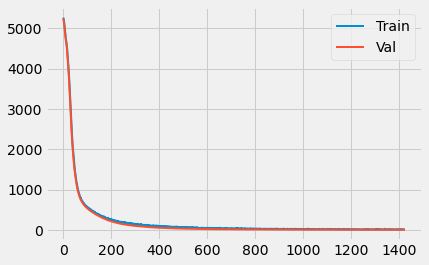

In [24]:
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

### 1.5 Evaluate

In [25]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
1/1 [==============================] - 0s 36ms/step - loss: 9.5849 - acc: 0.9982
Done.
Test loss: 9.584897994995117
Test accuracy: 0.9981536269187927


#### Exercise 1.4.1

Add one more hidden GAT layer, build, compile, train and evaluate the model.

In [ ]:
# Inputs
in_x = keras.Input(shape=(dataset[0].x.shape[1],))
in_a = keras.Input(shape=(dataset[0].a.shape[0],), sparse=True)

# Add dropout on features (but not adjacency matrix)
dropout_1 = keras.layers.Dropout(.1)(in_x)

# Add GAT layer
gat_layer_1 = spktrl.layers.GATConv(
    channels=16,
    attn_heads=8,
    concat_heads=True,
    dropout_rate=.05,
    activation='selu',
    kernel_initializer='lecun_normal'
)([dropout_1, in_a])

# Add dropout
dropout_2 = keras.layers.Dropout(.1)(gat_layer_1)



######## YOUR CODE STARTS HERE ########

# Add another GAT layer
gat_layer_2 = ...

# Add another dropout layer
dropout_3 = ...

######## YOUR CODE ENDS HERE ########


# Final GAT layer
gat_out = spktrl.layers.GATConv(
    channels=dataset[0].n_labels,
    attn_heads=8,
    concat_heads=False,
    dropout_rate=.05,
    activation='softmax'
)([dropout_3, in_a])

In [ ]:
# Enclose the layers in the model
model = keras.Model(inputs=[in_x, in_a], outputs=gat_out)

# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10000  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

# Compile the model
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=PATIENCE//2, min_lr=5e-6, factor=.9)
]



######## YOUR CODE STARTS HERE ########
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=...,
    epochs=EPOCHS,
    callbacks=...
)
######## YOUR CODE ENDS HERE ########

In [ ]:
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

In [ ]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

## 2. Graph classification with model sub-classing API

We'll use **Proteins** dataset, a part of [TU Datasets](https://chrsmrrs.github.io/datasets/).

Proteins dataset is stored in a **disjoint** format.



<img src="img/disjoint.png" width=400>


We'll need not only adjacency matrix and feature matrix, but also index matrix to identify which nodes belong to which batch.

### 2.1 Get the data

In [9]:
dataset = TUDataset("PROTEINS", clean=True)

100%|████████████████████████████████████████| 433k/433k [00:00<00:00, 2.97MB/s]


Successfully loaded PROTEINS.


#### Exercise 2.1.1

Check how many nodes are in the 8th graph of **Proteins** dataset.

How many are there in 172nd?

In [10]:
# YOUR CODE HERE
dataset[5]

Graph(n_nodes=108, n_node_features=4, n_edge_features=None, n_labels=2)

### 2.2 Split + dataloaders

In [29]:
# Train / test split
idxs = np.random.permutation(len(dataset))  # Random split
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])

# Get train and test datsets
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

# Get loaders 
loader_tr = DisjointLoader(dataset_tr, batch_size=32, epochs=10)
loader_te = DisjointLoader(dataset_te, batch_size=32, epochs=1)

### 2.3 Define the model

In [30]:
class GCN(keras.models.Model):
    
    def __init__(self, channels, n_layers, dropout_rate=.2):
        
        super().__init__()
        
        self.conv1 = spktrl.layers.GCNConv(channels)
        self.convs = []
        
        for _ in range(1, n_layers):
            self.convs.append(
                spktrl.layers.GCNConv(channels)
            )
        self.pool = spktrl.layers.GlobalAvgPool()
        self.dense1 = keras.layers.Dense(channels, activation='relu')
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(dataset.n_labels, activation='softmax')

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

### 2.3 Compile, train & evaluate 

#### 2.3.1 Setup

In [31]:
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 10  # Number of training epochs
PATIENCE = 30  # Patience for early stopping

In [32]:
# Instantiate the model
model = GCN(
    channels=16,
    dropout_rate=.1,
    n_layers=2
)

In [33]:
# Define the optimizer
optimizer = keras.optimizers.RMSprop(LR)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)


In [34]:
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_te.load(),
    validation_steps=loader_te.steps_per_epoch,
    epochs=EPOCHS
)

Epoch 1/10
 7/28 [======>.......................] - ETA: 0s - loss: 258.7665 - acc: 0.4866

C:\Users\aleks\anaconda3\envs\tf-spektral-minimal\lib\site-packages\spektral\data\utils.py:213: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


28/28 [==============================] - 5s 22ms/step - loss: 123.7635 - acc: 0.5576 - val_loss: 23.7878 - val_acc: 0.3367
Epoch 2/10
28/28 [==============================] - 1s 25ms/step - loss: 25.2934 - acc: 0.6237
Epoch 3/10
28/28 [==============================] - 0s 10ms/step - loss: 22.1513 - acc: 0.6556
Epoch 4/10
28/28 [==============================] - 0s 10ms/step - loss: 21.1284 - acc: 0.6340
Epoch 5/10
28/28 [==============================] - 0s 10ms/step - loss: 21.0358 - acc: 0.6465
Epoch 6/10
28/28 [==============================] - 0s 11ms/step - loss: 20.9220 - acc: 0.6465
Epoch 7/10
28/28 [==============================] - 0s 11ms/step - loss: 20.8778 - acc: 0.6465
Epoch 8/10
28/28 [==============================] - 0s 11ms/step - loss: 20.6952 - acc: 0.6465
Epoch 9/10
28/28 [==============================] - 0s 14ms/step - loss: 20.6270 - acc: 0.6465
Epoch 10/10
28/28 [==============================] - 0s 11ms/step - loss: 20.6415 - acc: 0.6465


#### Exercise 2.3.1

Train a GCN with:

* 32 channels 
* 6 layers
* Adam optimizer (use the same learning rate, `LR`)

Are the results better?

In [ ]:
# Get loaders 
loader_tr = DisjointLoader(dataset_tr, batch_size=32, epochs=10)
loader_te = DisjointLoader(dataset_te, batch_size=32, epochs=1)

######## YOUR CODE STARTS HERE ########
model = ...

# Define the optimizer
optimizer = ...

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_te.load(),
    validation_steps=loader_te.steps_per_epoch,
    epochs=EPOCHS
)

## 3. Building a custom dataset

To build your own dataset, you should store your data in a specific location. 

Locally it's: `~/.spektral/datasets/[ClassName]`

You can overwrite it by defining the `path` property of a `Dataset` class. 



Path on **Colab**: `/usr/local/lib/python3.7/dist-packages/spectral/datasets`


___________________________

<img src="img/tensorcell.png" width=150>

<br>

Now, we're going to look at a dataset class that we used in one of our experiments at [TensorCell](https://www.tensorcell.com/)




___________________________

In [ ]:
class TensorcellDataset(Dataset):
    
    """A Tensorcell dataset."""
    
    def __init__(self, dataset_variant, allow_self_loops=True, circular_mapping=False, add_constant_feature=False, add_one_hot_index=False, **kwargs):
        """
        :param dataset_variant: A dataset to pick. Currently takes: `ochota_100k`, `centrum_100k`, `mokotow_100k`
        :type dataset_variant: str
        :param circular_mapping: If node values should be mapped to a unit circle
        :type circular_dataset: bool

        ...
        :return: None
        :rtype: None
        """

        self.dataset_variant = dataset_variant
        self.allow_self_loops = allow_self_loops
        self.circular_mapping = circular_mapping
        self.add_constant_feature = add_constant_feature
        self.add_one_hot_index = add_one_hot_index
        
        # Construct filenames
        dataset_info = dataset_variant.split('_')
        district = dataset_info[0]
        n_rows = dataset_info[1]
        
        self.filename_A = f'{district}_A.txt'
        self.filename_Xy = f'{district}_X_{n_rows}.txt'

        super().__init__(**kwargs)


    def read(self):
        
        """
        :return: output
        :rtype: list
        """
        
        # We must return a list of Graph objects
        output = []
        
        # Read files
        adjacency_matrix = np.loadtxt(os.path.join(self.path, self.filename_A))
        features = np.loadtxt(os.path.join(self.path, self.filename_Xy), delimiter=',')

        # Add/remove self loops in the adjacency matrix
        if self.allow_self_loops:
            np.fill_diagonal(adjacency_matrix, 1)
        else:
            np.fill_diagonal(adjacency_matrix, 0)

        
        # Construct graph objects
        for row in range(features.shape[0]):

            # If `circular_mapping` -> map to a circular representation
            if self.circular_mapping:
                x = self.get_circular_components(features[row, :-1]).T
            else:
                x = features[row, :-1][:, np.newaxis]

            # Add constant feature 1
            if self.add_constant_feature:
                x = np.hstack([x, np.ones(x.shape[0])[:, np.newaxis]])

            # Add one-hot encoded node label
            if self.add_one_hot_index:

                x_plus_oh = []

                for i, d in enumerate(x):
                    one_hot_index = np.zeros(x.shape[0])
                    one_hot_index[i] = 1
                    x_plus_oh.append(np.hstack([d, one_hot_index]))

                x = np.array(x_plus_oh)

            # Construct a graph 
            output.append(
                Graph(
                    x=x, 
                    a=adjacency_matrix, 
                    y=features[row, -1])
            )

        return output

In [ ]:
dataset = TensorcellDataset('ochota_100k')